# Исследование влияния архитектурных изменений сверточной нейронной сети на качество распознавания на примере набора MNIST

Проведите серию экспериментов по подбору гиперпараметров нейронной сети, созданной на занятии.

1. Поменяйте количество нейронов в сверточных слоях, использовав следующие значения:

    - один слой 2 нейрона
    - один слой 4 нейрона
    - один слой 16 нейронов

2. Поменяйте активационную функцию в скрытых слоях с `relu` на `linear`
3. Поменяйте размеры `batch_size`:

    - 10
    - 100
    - Вся база (50000)

4. Запишите в таблицу получившиеся точности.
5. Напишите выводы по результатам проведенных тестов.

In [1]:
import logging
import os
from pathlib import Path
import sys
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.callbacks import History
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,  
    Dropout, 
    Flatten,
    MaxPooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

from PIL import Image
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

Установить уровень диагностических сообщений для TensorFlow.

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

Отобразить список доступных устройств.

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Задать количество эпох для обучения.

In [4]:
EPOCHS = 15

Создать датафрейм для хранения результатов тестирования.

In [5]:
report = pd.DataFrame(
    index=pd.MultiIndex.from_tuples([], names=("Категория", "Значение")),
    columns=['train', 'validation', 'test']
)

Определить вспомогательную функцию для визуализации процесса обучения.

In [6]:
def plot_history(
    history: History, 
    subtitle: str, 
    axes: Optional[np.ndarray] = None
) -> None:
    if axes is None or not axes.all():
        _, axes = plt.subplots(1, 2, figsize=(12, 5))
        show_plot = True
    else:
        show_plot = False

    axes[0].plot(
        history.epoch,
        history.history['loss'],
        color='steelblue',
        label='train set'
    )
    axes[0].plot(
        history.epoch,
        history.history['val_loss'],
        color='darkblue',
        label='validation set'
    )
    axes[0].set_title(f"Изменение loss: {subtitle}")
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(
        history.epoch,
        history.history['accuracy'],
        color='salmon',
        label='train set'
    )
    axes[1].plot(
        history.epoch,
        history.history['val_accuracy'],
        color='darkred',
        label='validation set'
    )
    axes[1].set_title(f"Изменение accuracy: {subtitle}")
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].grid(True)
    axes[1].legend()

    if show_plot:
        plt.show()

Задать путь для сохранения моделей нейронных сетей.

In [7]:
path = Path.home() / 'aiu-03-mnist-light-models'
if not path.exists():
    Path.mkdir(path, parents=True)

## Подготовка данных

Загрузка данных MNIST:

In [8]:
(x_org, y_org), (x_test_org, y_test_org) = mnist.load_data()

In [9]:
print(f"{x_org.shape}, {x_test_org.shape}")

(60000, 28, 28), (10000, 28, 28)


Отобразить примеры цифр из набора

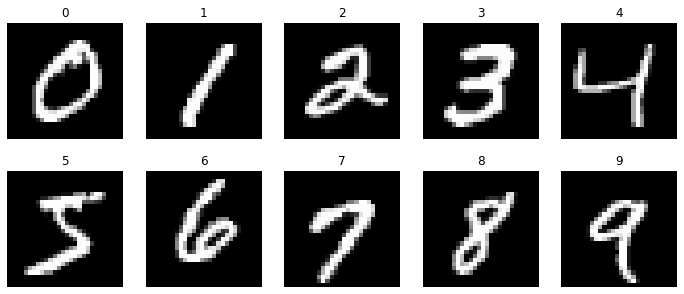

In [10]:
digits = np.unique(y_org)

_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for digit, ax in zip(digits, axes):
    ax.imshow(
        Image.fromarray(x_org[y_org == digit][0]).convert('RGB')
    )

    ax.set_title(str(digit))
    ax.set_axis_off()

plt.show();

Изменить формат входных изображений:

In [11]:
x = x_org[:, :, :, np.newaxis] / 255
x_test = x_test_org[:, :, :, np.newaxis] / 255

In [12]:
print(f"{x.shape}, {x_test.shape}")

(60000, 28, 28, 1), (10000, 28, 28, 1)


Преобразовать ответы в унитарный код (one-hot)

In [13]:
y = utils.to_categorical(y_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

In [14]:
print(f"{y.shape}, {y_test.shape}")

(60000, 10), (10000, 10)


Выделить обучающую и валидационную выборки.

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=10000)

In [16]:
print(f"{x_train.shape}, {x_val.shape}")

(50000, 28, 28, 1), (10000, 28, 28, 1)


## Создание и обучение эталонной модели сверточной нейронной сети

Вспомогательный класс для создания нейронной сети заданной архитектуры.

In [17]:
class ConvNet:

    @staticmethod
    def build(conv_layers: Tuple[int,...], activation='relu') -> Sequential:
        model = Sequential()

        model.add(BatchNormalization(input_shape=(28, 28, 1)))
        for channels in conv_layers:
            model.add(
                Conv2D(
                    channels,
                    (3, 3),
                    padding='same',
                    activation=activation
                )
            )
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(256, activation=activation))
        model.add(Dropout(0.25))
        model.add(Dense(10, activation='softmax'))

        model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy']
        )

        return model

Создать эталонную модель сверточной нейронной сети:

In [18]:
net = ConvNet.build(conv_layers=(32, 32))

print(net.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1605888   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

Обучить нейронную сеть.

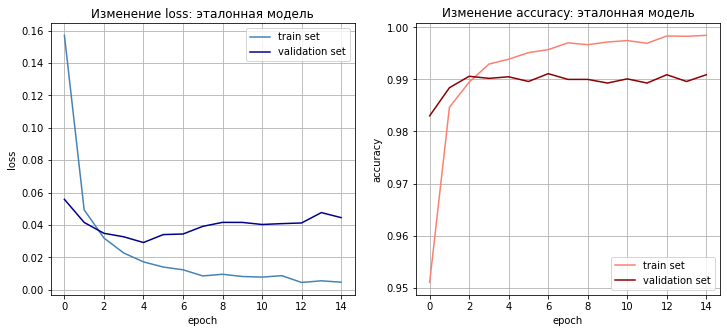

In [19]:
history = net.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    verbose=0
)

plot_history(history, subtitle="эталонная модель");

Сохранить архитектуру нейронной сети.

In [20]:
net.save(path / 'aiu-03-mnist-light-model-32+32')

Получить значения loss и accuracy для тестовой выборки.

In [21]:
score = net.evaluate(x_test, y_test, verbose=0)

print(f"Test loss: {score[0]:.5f}\nTest accuracy: {score[1]:.5f}")

Test loss: 0.04170
Test accuracy: 0.99170


Записать результаты в отчет.

In [22]:
def update_report(
    report: pd.DataFrame,
    category: str,
    value: str,
    history: History,
    score: List[int]
) -> None:
    report.loc[(category, value), :] = [
        history.history['accuracy'][-1],
        history.history['val_accuracy'][-1],
        score[1]
    ]

In [23]:
update_report(report, "Эталонная модель", "(32, 32)", history, score)

## Исследование влияния количества нейронов в сверточных слоях

Создать список, в котором заданы количество нейронов в сверточных слоях.

In [24]:
conv_layers_lst = [(j, 32) if i == 0 else (32, j) for i in range(2)
                                                  for j in (2, 4, 16)]

Обучить нейронные сети заданной архитектуры.

Done: 100%|██████████| 6/6 [02:09<00:00, 21.55s/it]


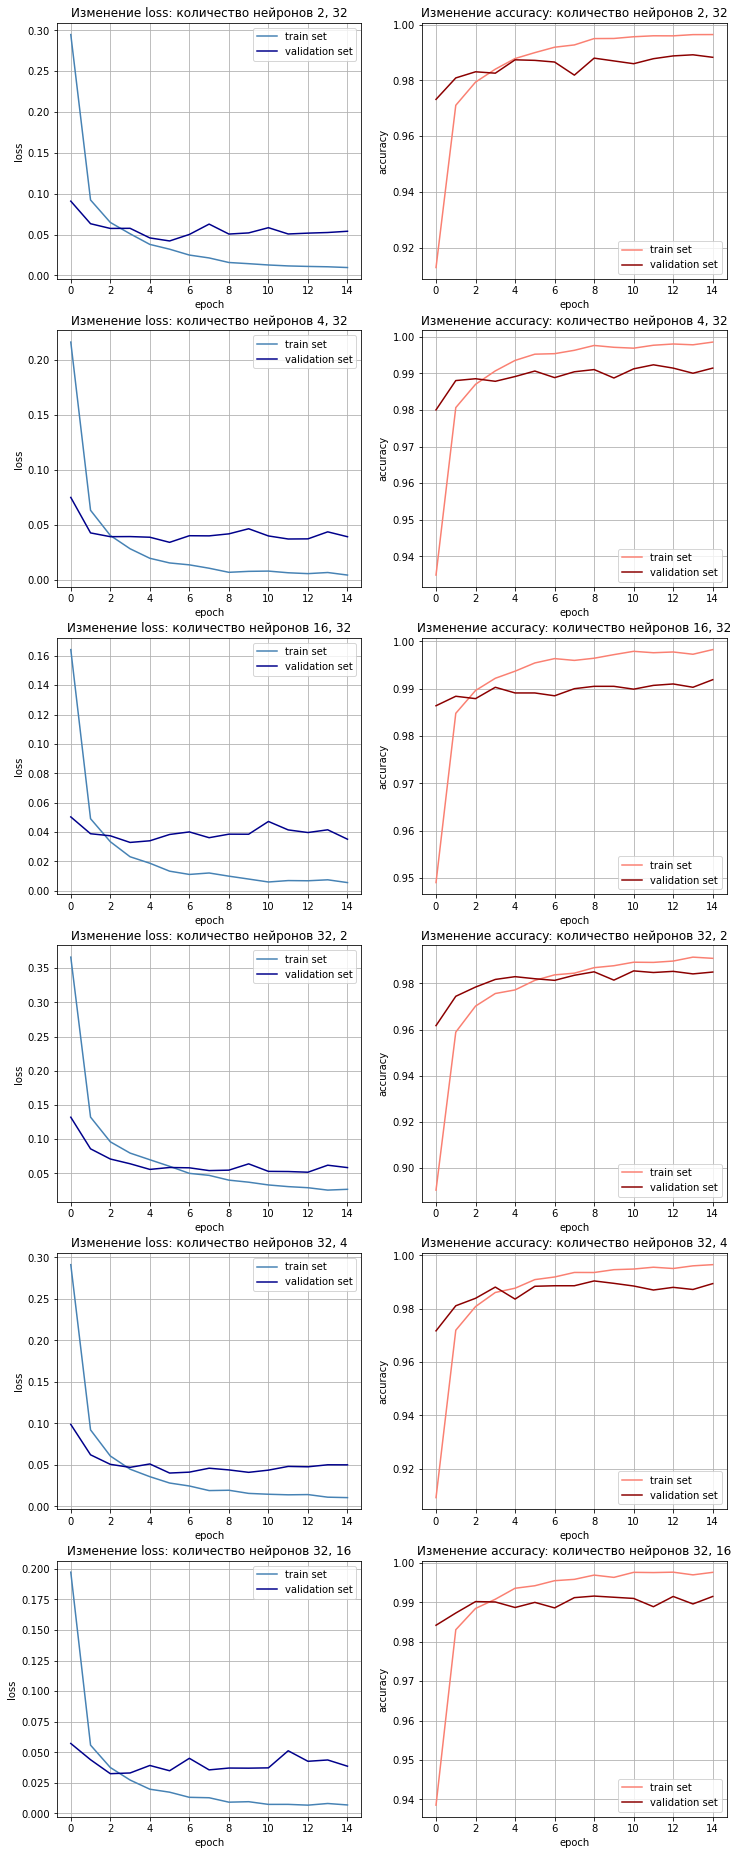

In [25]:
_, axes = plt.subplots(
    len(conv_layers_lst), 
    2,
    figsize=(12, 5.5 * len(conv_layers_lst))
)
axes = axes.flatten()

with tqdm(total=len(conv_layers_lst), desc="Fitting", file=sys.stdout) as pbar:
    for i, conv_layers in enumerate(conv_layers_lst):
        net = ConvNet.build(conv_layers=conv_layers)

        history = net.fit(
            x_train,
            y_train,
            batch_size=128,
            epochs=EPOCHS,
            validation_data=(x_val, y_val),
            verbose=0
        )
        plot_history(
            history, 
            subtitle="количество нейронов {}, {}".format(*conv_layers),
            axes=axes[2*i:2*i+2]
        )

        net.save(path / 'aiu-03-mnist-light-model-{}+{}'.format(*conv_layers))

        score = net.evaluate(x_test, y_test, verbose=0)
        update_report(
            report,
            "Количество нейронов",
            str(conv_layers),
            history,
            score
        )

        pbar.update()
        pbar.refresh()

    pbar.set_description("Done")

plt.show();

## Исследование влияния изменения активационной функции скрытых слоев на `linear`

Создать нейронную сеть с активационной функцией `linear` в скрытых слоях.

In [26]:
net = ConvNet.build(conv_layers=(32, 32), activation='linear')

print(net.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               1605888   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

Обучить нейронную сеть.

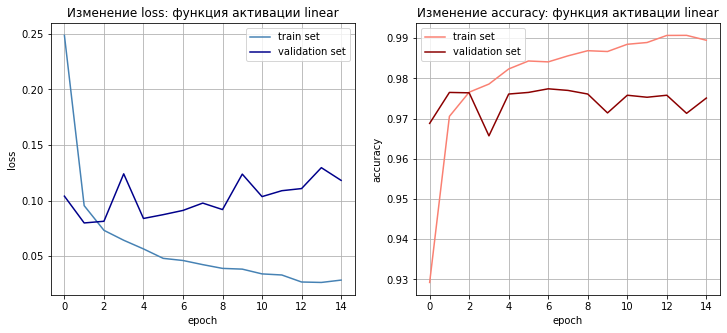

In [27]:
history = net.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    verbose=0
)

plot_history(history, subtitle="функция активации linear");

Сохранить архитектуру нейронной сети.

In [28]:
net.save(path / 'aiu-03-mnist-light-model-linear')

Получить значения loss и accuracy для тестовой выборки.

In [29]:
score = net.evaluate(x_test, y_test, verbose=0)

print(f"Test loss: {score[0]:.5f}\nTest accuracy: {score[1]:.5f}")

Test loss: 0.12025
Test accuracy: 0.97420


Записать результаты в отчет.

In [30]:
update_report(report, "Функция активации", "linear", history, score)

## Исследование влияния размера пакета `batch_size`

Обучить нейронные сети эталонной архитектуры, используя заданные размеры пакета.

Done: 100%|██████████| 7/7 [04:32<00:00, 38.87s/it]


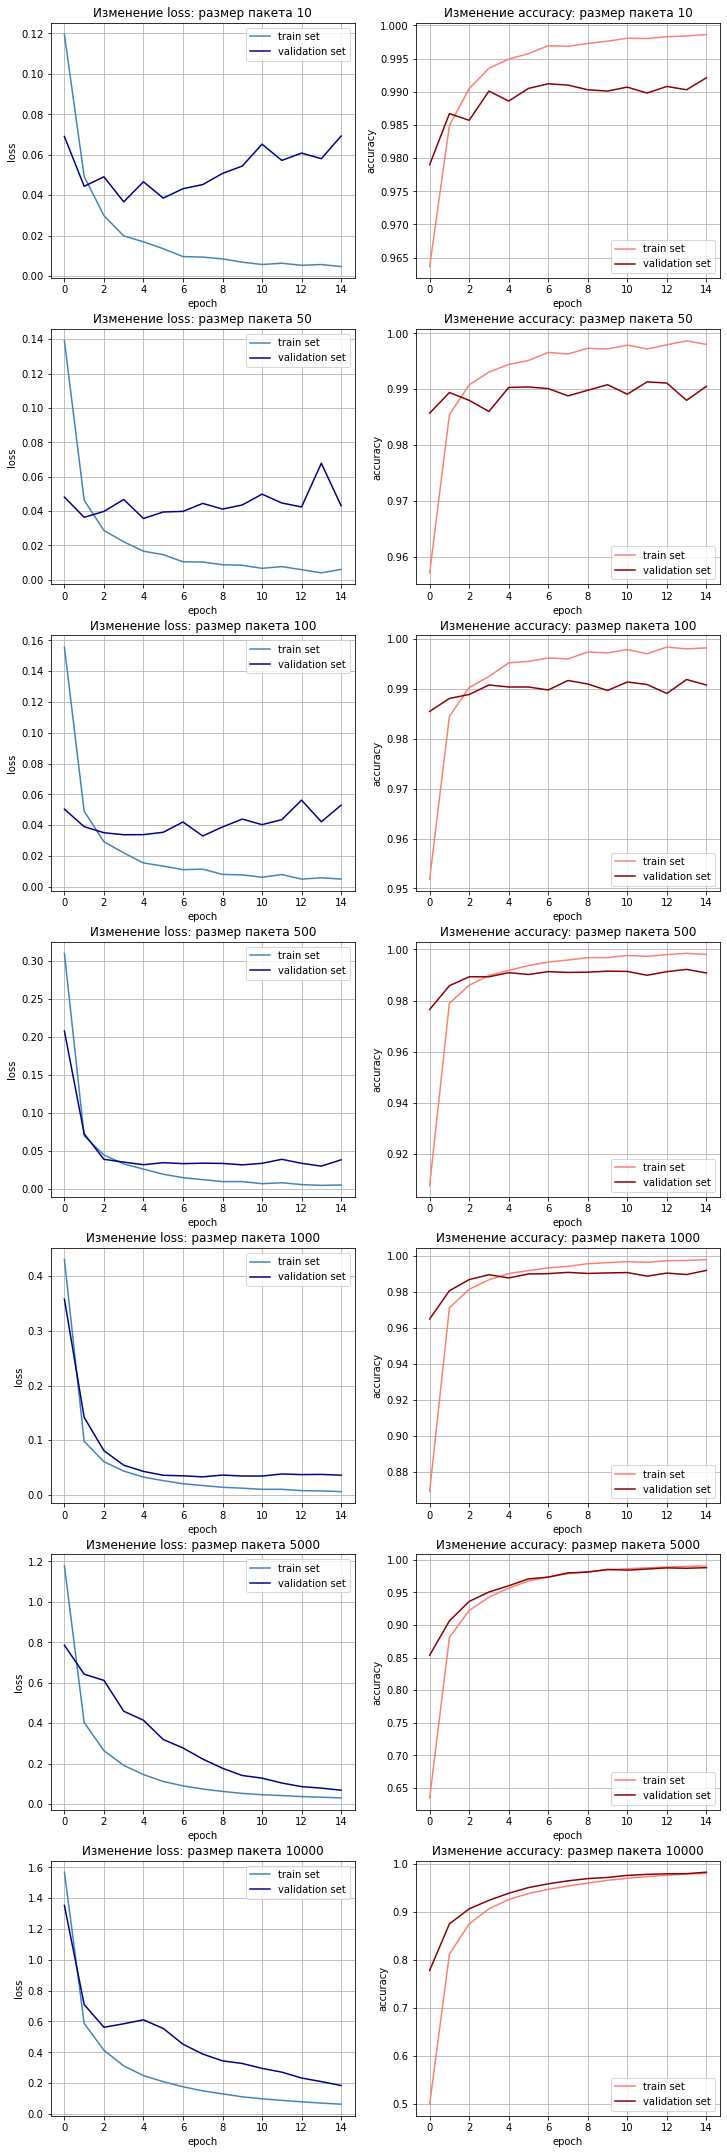

In [31]:
batch_sizes = (10, 50, 100, 500, 1000, 5000, 10000)

_, axes = plt.subplots(
    len(batch_sizes), 
    2,
    figsize=(12, 5.5 * len(batch_sizes))
)
axes = axes.flatten()

with tqdm(total=len(batch_sizes), desc="Fitting", file=sys.stdout) as pbar:
    for i, batch_size in enumerate(batch_sizes):
        net = ConvNet.build(conv_layers=(32, 32))

        history = net.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=EPOCHS,
            validation_data=(x_val, y_val),
            verbose=0
        )
        plot_history(
            history, 
            subtitle="размер пакета {}".format(batch_size),
            axes=axes[2*i:2*i+2]
        )

        net.save(path / 'aiu-03-mnist-light-model-bs{}'.format(batch_size))

        score = net.evaluate(x_test, y_test, verbose=0)
        update_report(
            report,
            "Размер пакета для (32, 32)",
            str(batch_size),
            history,
            score
        )

        pbar.update()
        pbar.refresh()

    pbar.set_description("Done")

plt.show();

Для избежания исключения для больших размеров `batch_size` уменьшеть число нейронов в сверточных слоях до 4. Обучить нейронные сети полученной архитектуры, используя заданные размеры пакета.

Done: 100%|██████████| 3/3 [02:27<00:00, 49.08s/it]


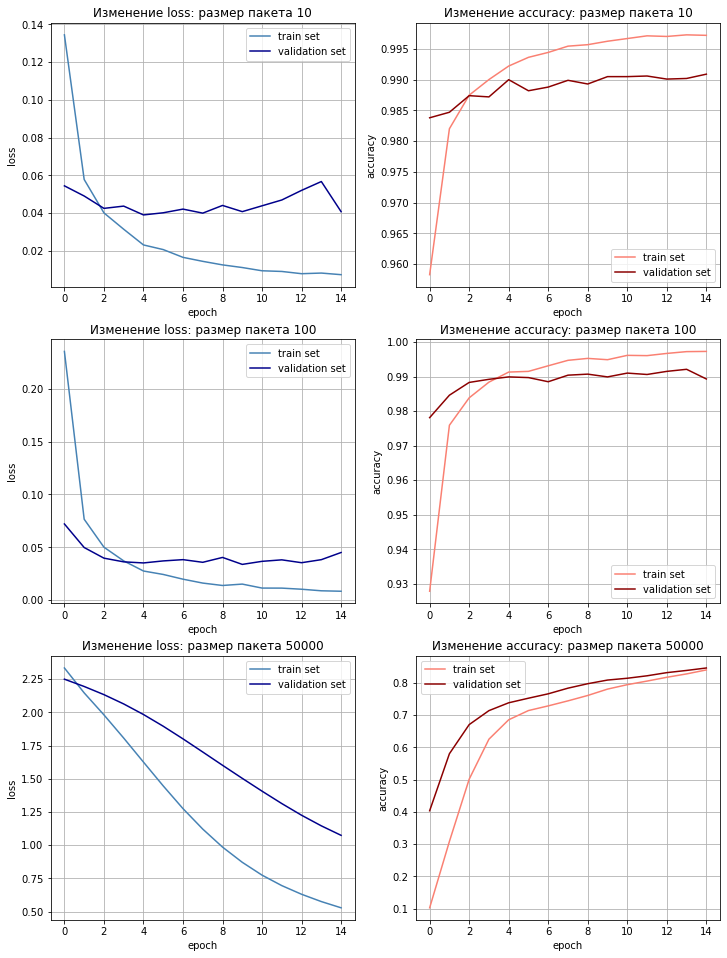

In [32]:
batch_sizes = (10, 100, x_train.shape[0])

_, axes = plt.subplots(
    len(batch_sizes), 
    2,
    figsize=(12, 5.5 * len(batch_sizes))
)
axes = axes.flatten()

with tqdm(total=len(batch_sizes), desc="Fitting", file=sys.stdout) as pbar:
    for i, batch_size in enumerate(batch_sizes):
        net = ConvNet.build(conv_layers=(8, 8))

        history = net.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=EPOCHS,
            validation_data=(x_val, y_val),
            verbose=0
        )
        plot_history(
            history, 
            subtitle="размер пакета {}".format(batch_size),
            axes=axes[2*i:2*i+2]
        )

        net.save(path / 'aiu-03-mnist-light-model-bsr{}'.format(batch_size))

        score = net.evaluate(x_test, y_test, verbose=0)
        update_report(
            report,
            "Размер пакета для (8, 8)",
            str(batch_size),
            history,
            score
        )

        pbar.update()
        pbar.refresh()

    pbar.set_description("Done")

plt.show();

## Выводы

Отобразить сводную таблицу с результатами исследования.

In [33]:
report

train validation    test
Категория                  Значение                            
Эталонная модель           (32, 32)  0.99846     0.9909  0.9917
Количество нейронов        (2, 32)   0.99646     0.9883  0.9875
                           (4, 32)    0.9985     0.9914  0.9892
                           (16, 32)  0.99826     0.9919  0.9899
                           (32, 2)   0.99084     0.9849  0.9823
                           (32, 4)    0.9965     0.9894  0.9889
                           (32, 16)  0.99762     0.9915  0.9888
Функция активации          linear    0.98948     0.9751  0.9742
Размер пакета для (32, 32) 10        0.99862     0.9921  0.9901
                           50        0.99802     0.9905  0.9904
                           100       0.99824     0.9908  0.9904
                           500       0.99804     0.9908  0.9911
                           1000      0.99808     0.9921  0.9894
                           5000      0.99042     0.9877  0.9867
                           10000     0.98064     0.9833  0.9821
Размер пакета для (8, 8)   10        0.99722     0.9909  0.9889
                           100       0.99728     0.9893  0.9879
                           50000      0.8396     0.8456  0.8554

### Исследование влияния количества нейронов в скрытых слоях на величину accuracy

Получить данные для эталонной модели.

In [34]:
query_rm = report.xs("Эталонная модель", level="Категория", axis=0, drop_level=True)

In [35]:
query_rm

,train,validation,test
Значение,,,
"(32, 32)",0.99846,0.9909,0.9917


Получить данные для различного количества нейронов в сверточных слоях.

In [36]:
query = report.xs("Количество нейронов", level="Категория", axis=0, drop_level=True)

In [37]:
query

,train,validation,test
Значение,,,
"(2, 32)",0.99646,0.9883,0.9875
"(4, 32)",0.9985,0.9914,0.9892
"(16, 32)",0.99826,0.9919,0.9899
"(32, 2)",0.99084,0.9849,0.9823
"(32, 4)",0.9965,0.9894,0.9889
"(32, 16)",0.99762,0.9915,0.9888


Объединить полученные данные с данными эталонной модели.

In [38]:
query = pd.concat([query_rm, query])

In [39]:
query

,train,validation,test
Значение,,,
"(32, 32)",0.99846,0.9909,0.9917
"(2, 32)",0.99646,0.9883,0.9875
"(4, 32)",0.9985,0.9914,0.9892
"(16, 32)",0.99826,0.9919,0.9899
"(32, 2)",0.99084,0.9849,0.9823
"(32, 4)",0.9965,0.9894,0.9889
"(32, 16)",0.99762,0.9915,0.9888


Отобразить столбчатую диаграмму значений accuracy.

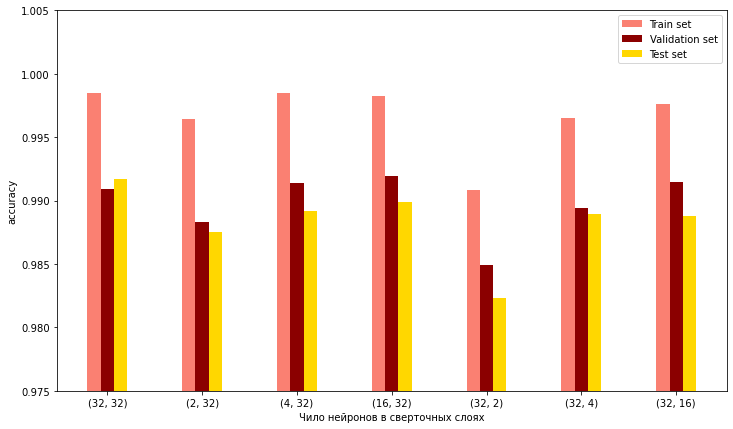

In [40]:
t = np.arange(len(query.index))
width = 0.14

_, ax = plt.subplots(figsize=(12, 7))

ax.bar(
    t - width, 
    query.loc[:, 'train'], 
    width, 
    color='salmon',
    label='Train set'
)
ax.bar(
    t, 
    query.loc[:, 'validation'], 
    width, 
    color='darkred',
    label='Validation set'
)
ax.bar(
    t + width, 
    query.loc[:, 'test'], 
    width, 
    color='gold',
    label='Test set'
)

ax.set_ylabel("accuracy")
ax.set_ylim((0.975, 1.005))
ax.set_xlabel("Чило нейронов в сверточных слоях")
ax.set_xticks(t)
ax.set_xticklabels(str(value) for value in query.index)
ax.legend()

plt.show();

Таким образом, если в первом сверточном слое нейронов меньше, чем во втором, то значение `accuracy` на валидационной и тестовой выборках оказывается если не лучше, то хотя бы сопостовимо с соответствующими значениями для эталонной модели. Если число нейронов во втором сверточном слое меньше числа нейронов в первом сверточном слое, то значение `accuracy` для валидационной и тестовой выборок меньше соотвествующих значений для эталонной модели. На основании этого можно сделать предположение: число нейронов в последующем сверточном слое должно быть не меньше числа нейронов в текущем сверточном слое.

## Исследование влияния замены функции активации в скрытых слоях на величину accuracy

Получить данные для активационной функции `linear`.

In [41]:
query = report.xs("Функция активации", level="Категория", axis=0, drop_level=True)

In [42]:
query

,train,validation,test
Значение,,,
linear,0.98948,0.9751,0.9742


Объединить полученные данные с данными эталонной модели.

In [43]:
query = pd.concat([query_rm, query])

In [44]:
query

,train,validation,test
Значение,,,
"(32, 32)",0.99846,0.9909,0.9917
linear,0.98948,0.9751,0.9742


Отобразить столбчатую диаграмму значений accuracy.

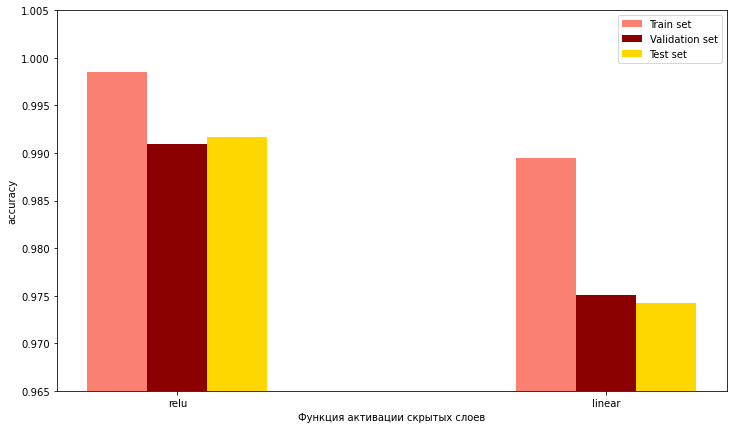

In [45]:
t = np.arange(len(query.index))
width = 0.14

_, ax = plt.subplots(figsize=(12, 7))

ax.bar(
    t - width, 
    query.loc[:, 'train'], 
    width, 
    color='salmon',
    label='Train set'
)
ax.bar(
    t, 
    query.loc[:, 'validation'], 
    width, 
    color='darkred',
    label='Validation set'
)
ax.bar(
    t + width, 
    query.loc[:, 'test'], 
    width, 
    color='gold',
    label='Test set'
)

ax.set_ylabel("accuracy")
ax.set_ylim((0.965, 1.005))
ax.set_xlabel("Функция активации скрытых слоев")
ax.set_xticks(t)
ax.set_xticklabels(['relu', 'linear'])
ax.legend()

plt.show();

Таким образом, замена активационной функции с `relu` на `linear` приводит к ухудшению предсказательных характеристик нейронной сети по тем же самым причинам, что и для полносвязных нейронных сетей.

## Исследование влияния размера пакета (`batch_size`) на величину accuracy

Поскольку для `batch_size` значение которого равно 50000 нейронная сеть с эталонной архитектурой выдает исключение, то исследуем влияние `batch_size` для значений от 10 до 10000. После чего построим регрессионную модель и попытаемся предсказать значение accuracy для `batch_size` равного 50000.

Порлучим данные для различных значений `batch_size` в случае использования нейронной сети с эталонной архитектурой.

In [46]:
query = report.xs("Размер пакета для (32, 32)", level="Категория", axis=0, drop_level=True)

In [47]:
query

,train,validation,test
Значение,,,
10,0.99862,0.9921,0.9901
50,0.99802,0.9905,0.9904
100,0.99824,0.9908,0.9904
500,0.99804,0.9908,0.9911
1000,0.99808,0.9921,0.9894
5000,0.99042,0.9877,0.9867
10000,0.98064,0.9833,0.9821


Построить графики зависимости accuracy от размера `batch_size`.

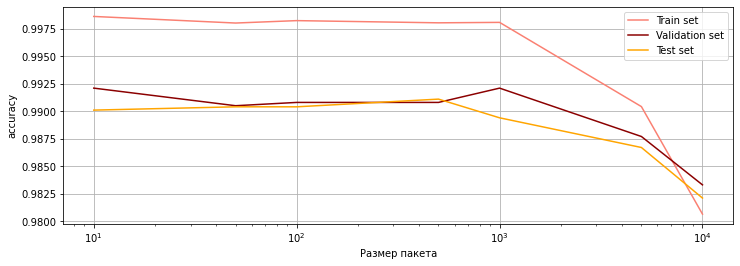

In [48]:
_, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.semilogx(
    query.index.astype(np.int),
    query.loc[:, 'train'],
    color='salmon',
    label='Train set'
)
axes.semilogx(
    query.index.astype(np.int),
    query.loc[:, 'validation'],
    color='darkred',
    label='Validation set'
)
axes.semilogx(
    query.index.astype(np.int),
    query.loc[:, 'test'],
    color='orange',
    label='Test set'
)

axes.set_ylabel('accuracy')
axes.set_xlabel('Размер пакета')
axes.grid(True)
axes.legend()

plt.show();

Построим регрессионную зависимость для обучающей выборки. Судя по характеру зависимости на последней визуализации, будем использовать линейное уравнение регрессии:

$$
\mathrm{accuracy} = intercept + slope\cdot\mathrm{batch\_size}.
$$

In [49]:
(
    slope,
    intercept,
    rvalue,
    pvalue,
    _
) = stats.linregress(
    query.index.astype(np.int), 
    query.loc[:, 'train'].astype(np.float)
)

Уравнение регрессии:

In [50]:
print("accuracy = {} {} {} * batch_size.".format(
    intercept,
    '-' if slope < 0.0 else '+',
    abs(slope)
))

accuracy = 0.9988225145863626 - 1.7825706743173924e-06 * batch_size.


In [51]:
print(f"Коэффициент корреляции: {rvalue}")
print(f"p-уровень значимости: {pvalue}")

Коэффициент корреляции: -0.9960488048053066
p-уровень значимости: 1.8808543072038783e-06


Значение коэффициента корреляции близкое по модулю к 1 указывает на сильную связь между accuracy и `batch_size`. Величина p-уровня значимости значительно меньше 0.01 указывает на то, что полученный результат является статистически значимым. Определим значение accuracy для тестовой выборки при размере пакета равном 50000:

In [52]:
print(f"Accuracy (train set): {intercept + slope * x_train.shape[0]}")

Accuracy (train set): 0.909693980870493


Построим регрессионную зависимость для валидационной выборки. Также будем искать уравнение регрессии в линейном виде.

In [53]:
(
    slope,
    intercept,
    rvalue,
    pvalue,
    _
) = stats.linregress(
    query.index.astype(np.int), 
    query.loc[:, 'validation'].astype(np.float)
)

Уравнение регрессии:

In [54]:
print("accuracy = {} {} {} * batch_size.".format(
    intercept,
    '-' if slope < 0.0 else '+',
    abs(slope)
))

accuracy = 0.9915226475573432 - 8.018341268022739e-07 * batch_size.


In [55]:
print(f"Коэффициент корреляции: {rvalue}")
print(f"p-уровень значимости: {pvalue}")

Коэффициент корреляции: -0.9675078584913835
p-уровень значимости: 0.0003591682360505628


Значение коэффициента корреляции близкое по модулю к 1 указывает на сильную связь между accuracy и `batch_size` (хотя и в меньшей степени, чем для обучающей выборки). Величина p-уровня значимости значительно меньше 0.01 указывает на то, что полученный результат является статистически значимым. Определим значение accuracy для тестовой выборки при размере пакета равном 50000:

In [56]:
print(f"Accuracy (validation set): {intercept + slope * x_train.shape[0]}")

Accuracy (validation set): 0.9514309412172295


Построим регрессионную зависимость для тестовой выборки. Также будем искать уравнение регрессии в линейном виде.

In [57]:
(
    slope,
    intercept,
    rvalue,
    pvalue,
    _
) = stats.linregress(
    query.index.astype(np.int), 
    query.loc[:, 'test'].astype(np.float)
)

Уравнение регрессии:

In [58]:
print(f"Коэффициент корреляции: {rvalue}")
print(f"p-уровень значимости: {pvalue}")

Коэффициент корреляции: -0.9889430565519177
p-уровень значимости: 2.454506644593592e-05


Значение коэффициента корреляции близкое по модулю к 1 указывает на сильную связь между accuracy и `batch_size` (хотя и в меньшей степени, чем для обучающей выборки). Величина p-уровня значимости значительно меньше 0.01 указывает на то, что полученный результат является статистически значимым. Определим значение accuracy для тестовой выборки при размере пакета равном 50000:

In [59]:
print(f"Accuracy (test set): {intercept + slope * x_train.shape[0]}")

Accuracy (test set): 0.9489229331073049


Таким образом, во всех трех случаях величина slope в уравнении регрессии получилась отрицательной, что говорит о том, что с ростом `batc_size` величина accuracy будет снижаться.

В качестве потверждения данного утверждения проанализируем данные обучения нейронной сети, у которой 8 нейронов в каждом сверточном слое. Порлучим данные для различных значений `batch_size` в случае использования нейронной сети с данной архитектурой.

In [60]:
query = report.xs("Размер пакета для (8, 8)", level="Категория", axis=0, drop_level=True)

In [61]:
query

,train,validation,test
Значение,,,
10,0.99722,0.9909,0.9889
100,0.99728,0.9893,0.9879
50000,0.8396,0.8456,0.8554


Отобразить столбчатую диаграмму значений accuracy.

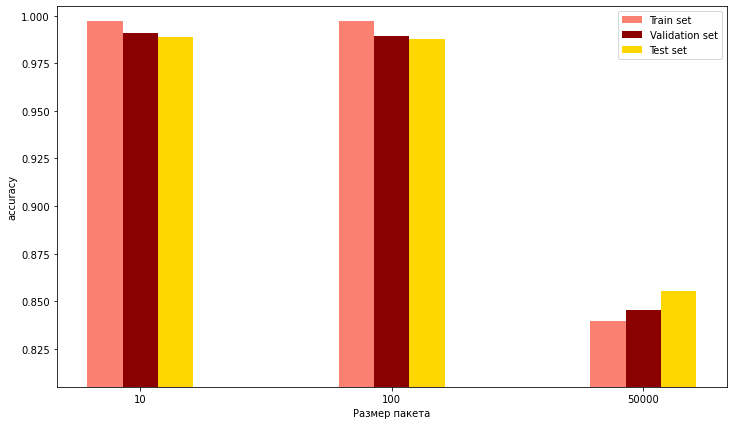

In [62]:
t = np.arange(len(query.index))
width = 0.14

_, ax = plt.subplots(figsize=(12, 7))

ax.bar(
    t - width, 
    query.loc[:, 'train'], 
    width, 
    color='salmon',
    label='Train set'
)
ax.bar(
    t, 
    query.loc[:, 'validation'], 
    width, 
    color='darkred',
    label='Validation set'
)
ax.bar(
    t + width, 
    query.loc[:, 'test'], 
    width, 
    color='gold',
    label='Test set'
)

ax.set_ylabel("accuracy")
ax.set_ylim((0.805, 1.005))
ax.set_xlabel("Размер пакета")
ax.set_xticks(t)
ax.set_xticklabels(str(value) for value in query.index)
ax.legend()

plt.show();

Таким образом, с увеличением значения `batch_size` величина accuracy значительно снижается на интервале от 100 до 50000, что также было ранее показано с использованием регрессионного анализа. Однако характер зависимости accuracy от `batch_size` скорее всего не является линейным.